# Análise exploratório dos dados #

O objetio deste relatório é entender um pouco sobre o comportamento dos dados baixados do Buscapé pelo crawler e ser capaz de identificar padrões.
Para alcançar este objeitos iremos estrutura o relatório em duas partes:  
1. Análise univariada
2. Análise multivariada

Explicando um pouco sobre os dados, estes foram obtidos através de uma varredura da lista de smartphones e celulares que o site do [Buscapé](http://www.buscape.com.br/celular-e-smartphone) oferece. Para cada página na lista, foram percorridos os items e, para aqueles que a empresa oferecia informações no seu próprio domínio, estes dados foram extraídos. É importante ressaltar que a extração não foi perfeita e dependia bastante das informações que o Buscapé oferecia. Então, em alguns casos, nem todas as informações estão completas, isto também inclúi o preço, pois o Buscapé lista items que o mesmo não possui em estoque e, logo, não expõe o valor do produto.

## 1. Análise univariada ##

Na análise univariada iremos estudar o comportamento de cada variável separadamente, idenficando os valores que as mesmas assumem e tentar encontrar alguns comportamentos interessantes ao observá-las isoladamente. Primeiro é importante deixar claro quais são as variáveis estudadas. Para isto, iremos já iniciar com um script para extrair o nome das colunas e o número de valores não-nulos que as mesmas possuem. Com isto, para cada coluna, será identificado quais são seus possíveis valores (e o tipo, categórico ou numérico) e então elaborado a distribuição da variável e medida de centralidade.

In [280]:
# imports and settings
import pandas
import os
import seaborn
import math

%matplotlib inline
seaborn.set(color_codes=True)

In [281]:
# data extraction
data_csv_path = os.path.join(os.getcwd(), "output", "data.csv")
buscape_data = pandas.read_csv(
    filepath_or_buffer=data_csv_path,
    sep=";"
)

buscape_data.head()

,camera_traseira,velocidade_do_processador,url,chips,resolucao,tamanho_da_tela,modelo,memoria_ram,linha,preco,camera_frontal,marca,memoria_interna
0,13.0 megapixels,1.6,http://www.buscape.com.br/smartphone-samsung-g...,dual,1920 x 1080,5.5,j7 prime sm-g610m,3.0,galaxy,999.00,8.0 megapixels frontal,samsung,32.0
1,13.0 megapixels,1.4,http://www.buscape.com.br/smartphone-motorola-...,dual,1920 x 1080,5.0,5 xt1672,2.0,moto g,798.00,5.0 megapixels frontal,motorola,32.0
2,13.0 megapixels,1.2,http://www.buscape.com.br/smartphone-samsung-g...,dual,720 x 1280,5.0,j5 sm-j500m,1.5,galaxy,599.45,5.0 megapixels frontal,samsung,16.0
3,8.0 megapixels,1.4,http://www.buscape.com.br/smartphone-samsung-g...,dual,540 x 960,5.0,j2 prime sm-g532m,1.5,galaxy,539.00,5.0 megapixels frontal,samsung,8.0
4,12.0 megapixels,NaN,http://www.buscape.com.br/smartphone-samsung-g...,NaN,1440 x 2960,5.8,s8 sm-g950,4.0,galaxy,2989.00,8.0 megapixels frontal,samsung,64.0


In [282]:
buscape_data.count()

camera_traseira              1354
velocidade_do_processador     464
url                          1683
chips                        1244
resolucao                    1355
tamanho_da_tela              1267
modelo                       1675
memoria_ram                   161
linha                         593
preco                         349
camera_frontal                524
marca                        1683
memoria_interna               574
dtype: int64

Tendo em mãos os nomes das variáveis que o csv possui, será feito uma análise de cada uma delas separadamente. Não serão consideradas as variáveis `URL`, `Modelo` e `Linha`. `URL` é somente um dado extra adicionado aos dados. Quanto à `Modelo` e `Linha`, estes podem ser substituídos pela `Marca`.


In [283]:
def transform_to_categorical_Data(series, fillna_value, ordered=True, custom_sort=lambda x: x):
    categories = series.fillna(fillna_value).unique()
    categories = sorted(categories,
                        key=custom_sort)
    
    return series.astype("category",
                         categories=categories,
                         ordered=ordered)

In [284]:
def order_camera_traseria_categories(value):
    value = value.split(" ")
    try:
        return float(value[0])
    except ValueError:
        return -1

camera_traseira = transform_to_categorical_Data(
    series=buscape_data["camera_traseira"],
    fillna_value="",
    custom_sort=order_camera_traseria_categories
)

camera_traseira.cat.categories

Index(['', 'vga', '0.1 megapixels', '0.3 megapixels', '0.5 megapixels',
       '1.0 megapixels', '1.2 megapixels', '1.3 megapixels', '2.0 megapixels',
       '2 megapixels', '3.0 megapixels', '3.1 megapixels', '3.15 megapixels',
       '3.2 megapixels', '3.5 megapixels', '4.0 megapixels', '5.0 megapixels',
       '5.1 megapixels', '6.7 megapixels', '8.0 megapixels', '8.1 megapixels',
       '8.7 megapixels', '10.0 megapixels', '11.0 megapixels',
       '12.0 megapixels', '12.1 megapixels', '13.0 megapixels',
       '13.1 megapixels', '16.0 megapixels', '20 megapixels',
       '20.7 megapixels', '21 megapixels', '21.5 megapixels', '23 megapixels',
       '41 megapixels'],
      dtype='object')

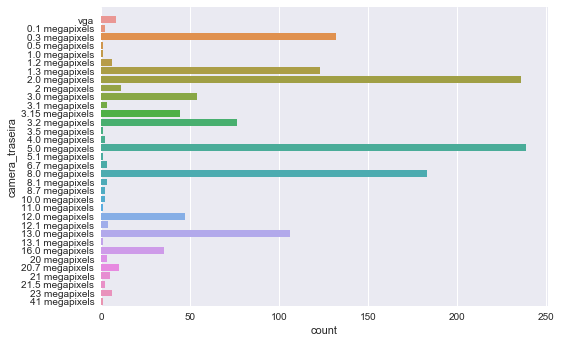

In [286]:
seaborn.countplot(y=camera_traseira)

In [287]:
velocidade_do_processador = transform_to_categorical_Data(
    series=buscape_data["velocidade_do_processador"],
    fillna_value=0.0
)

velocidade_do_processador.cat.categories

Float64Index([ 0.0,  1.0,  1.1,  1.2, 1.25,  1.3,  1.4, 1.43,  1.5,  1.6,  1.7,
               1.8,  1.9,  2.0,  2.1,  2.2, 2.26,  2.3, 2.35,  2.5,  2.7,  3.5,
               3.6],
             dtype='float64')

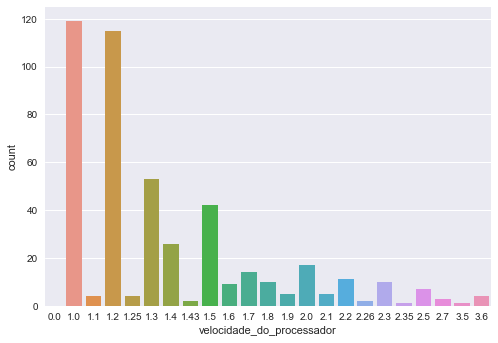

In [288]:
seaborn.countplot(x=velocidade_do_processador)

In [289]:
chips = transform_to_categorical_Data(
    series=buscape_data["chips"],
    fillna_value="",
    ordered=False
)

chips.cat.categories

Index(['', 'dual', 'quadri', 'single', 'tri'], dtype='object')

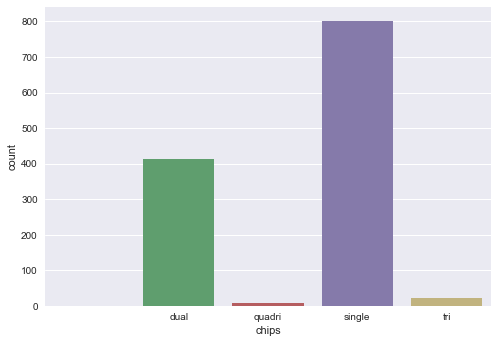

In [290]:
seaborn.countplot(x=chips)

In [291]:
def resolucao_data_order(value):
    value = value.replace(" ", "")
    dim = [float(dim) for dim in value.split("x")]
    return dim[0] * dim[1]

resolucao = transform_to_categorical_Data(
    series=buscape_data["resolucao"],
    fillna_value="0 x 0",
    ordered=True,
    custom_sort=resolucao_data_order
)

resolucao.cat.categories

Index(['0 x 0', '34 x 43', '96 x 54', '96 x 60', '128 x 48', '96 x 64',
       '96 x 65', '98 x 64', '96 x 68', '98 x 67', '112 x 64', '101 x 80',
       '128 x 64', '128 x 96', '128 x 128', '130 x 130', '120 x 160',
       '128 x 160', '160 x 128', '132 x 176', '176 x 144', '144 x 176',
       '128 x 220', '176 x 208', '240 x 160', '220 x 176', '176 x 220',
       '240 x 180', '208 x 208', '240 x 240', '240 x 260', '208 x 320',
       '340 x 220', '240 x 320', '320 x 240', '240 x 340', '240 x 400',
       '400 x 240', '240 x 480', '640 x 200', '360 x 400', '320 x 480',
       '480 x 320', '480 x 360', '360 x 480', '360 x 640', '640 x 360',
       '345 x 800', '640 x 480', '400 x 800', '800 x 460', '800 x 480',
       '480 x 800', '854 x 480', '480 x 854', '540 x 960', '960 x 540',
       '720 x 720', '960 x 640', '640 x 960', '960 x 650', '1136 x 640',
       '720 x 1280', '1280 x 720', '1280 x 768', '768 x 1280', '1334 x 750',
       '800 x 1280', '1280 x 800', '1920 x 1080', '1080 x

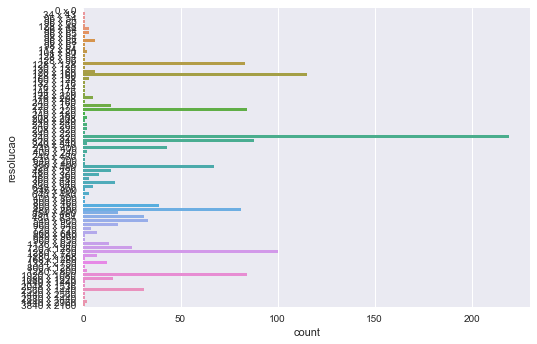

In [296]:
seaborn.countplot(y=resolucao)

In [298]:
tamanho = transform_to_categorical_Data(
    series=buscape_data["tamanho_da_tela"],
    fillna_value=0,
    ordered=True
)

tamanho.cat.categories

Float64Index([ 0.0, 1.43, 1.44, 1.45,  1.5, 1.52,  1.6,  1.7, 1.77, 1.79,  1.8,
              1.85, 1.87,  1.9,  2.0,  2.1,  2.2, 2.25,  2.3, 2.31, 2.36,  2.4,
              2.44, 2.46,  2.5, 2.55,  2.6,  2.7,  2.8,  2.9,  3.0,  3.1, 3.14,
               3.2, 3.25, 3.27,  3.3,  3.4,  3.5, 3.65,  3.7,  3.8, 3.97,  4.0,
               4.2, 4.27,  4.3,  4.5,  4.6, 4.65, 4.66,  4.7,  4.8, 4.93, 4.95,
              4.97,  5.0,  5.1,  5.2, 5.25,  5.3,  5.4,  5.5,  5.7, 5.79,  5.8,
              5.96,  6.0,  6.2,  6.3,  6.4],
             dtype='float64')

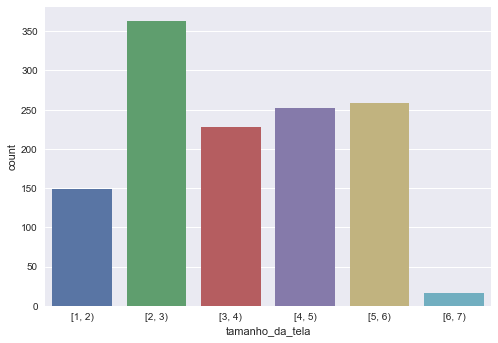

In [299]:
tamanho_cutted = pandas.cut(tamanho, range(1, 8), right=False)

seaborn.countplot(x=tamanho_cutted)

In [300]:
memoria_ram = transform_to_categorical_Data(
    series=buscape_data["memoria_ram"],
    fillna_value=0,
    ordered=True
)

memoria_ram.cat.categories

Float64Index([0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0], dtype='float64')

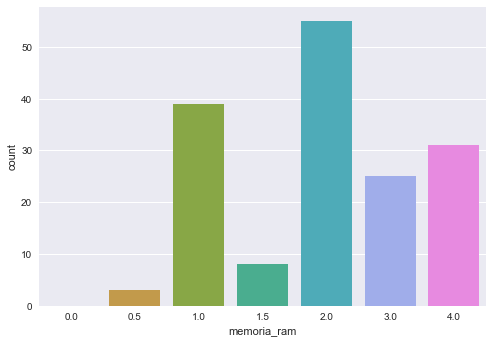

In [301]:
seaborn.countplot(x=memoria_ram)

In [302]:
camera_frontal = transform_to_categorical_Data(
    series=buscape_data["camera_frontal"],
    fillna_value="",
    ordered=True,
    custom_sort=order_camera_traseria_categories
)

camera_frontal.cat.categories

Index(['', 'vga', '0.1 megapixels frontal', '0.3 megapixels frontal',
       '0.9 megapixels frontal', '1.0 megapixels frontal',
       '1.1 megapixels frontal', '1.2 megapixels frontal',
       '1.3 megapixels frontal', '1.6 megapixels frontal',
       '1.9 megapixels frontal', '2.0 megapixels frontal',
       '2.1 megapixels frontal', '2.2 megapixels frontal',
       '3.7 megapixels frontal', '4 megapixels frontal',
       '5.0 megapixels frontal', '5.1 megapixels frontal',
       '7 megapixels frontal', '8.0 megapixels frontal',
       '13.0 megapixels frontal', '16 megapixels frontal'],
      dtype='object')

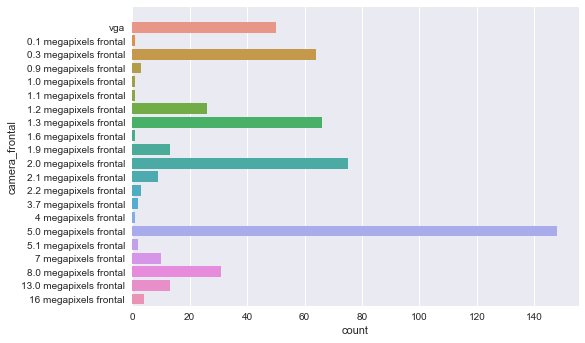

In [303]:
seaborn.countplot(y=camera_frontal)

In [304]:
marca = transform_to_categorical_Data(
    series=buscape_data["marca"],
    fillna_value="",
    ordered=False
)

marca.cat.categories

Index(['alcatel', 'apple', 'asus', 'b-mobile', 'bak', 'best', 'blackberry',
       'blu', 'bright', 'caterpillar', 'cce', 'dl', 'dotcom', 'elari',
       'foston', 'freecel', 'gradiente', 'hiphone', 'hp', 'htc', 'huawei',
       'intelbrás', 'ipro', 'kaiomy', 'kyocera', 'lenovo', 'lenoxx sound',
       'lg', 'meizu', 'meu', 'microsoft', 'midi', 'mirage', 'motorola', 'mox',
       'multilaser', 'navcity', 'nokia', 'octo', 'onda', 'palm', 'panasonic',
       'philco', 'positivo', 'powerpack', 'qbex', 'quantum', 'samsung',
       'semp toshiba', 'sendo', 'siemens', 'sony', 'sony ericsson', 'tp-link',
       'vaic', 'venko', 'xiaomi', 'zopo', 'zte'],
      dtype='object')

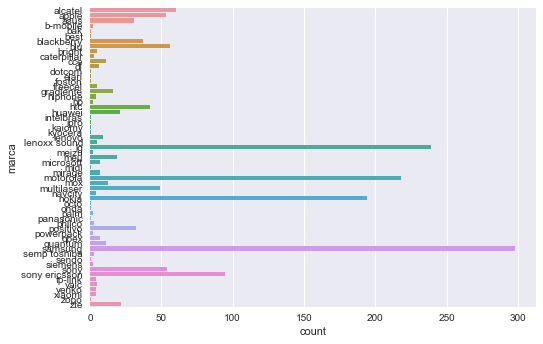

In [308]:
seaborn.countplot(y=marca)

In [308]:
memoria_interna = transform_to_categorical_Data(
    series=buscape_data["memoria_interna"],
    fillna_value=0,
    ordered=True
)

memoria_interna.cat.categories

Float64Index([0.0, 1.0, 1.5, 2.0, 3.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0,
              256.0],
             dtype='float64')

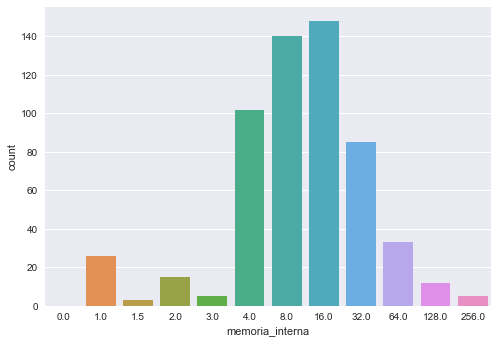

In [309]:
seaborn.countplot(x=memoria_interna)

In [310]:
preco = buscape_data["preco"]

preco.describe()

count     349.000000
mean     1131.410086
std       958.758670
min        64.900000
25%       473.000000
50%       799.000000
75%      1618.000000
max      4310.680000
Name: preco, dtype: float64

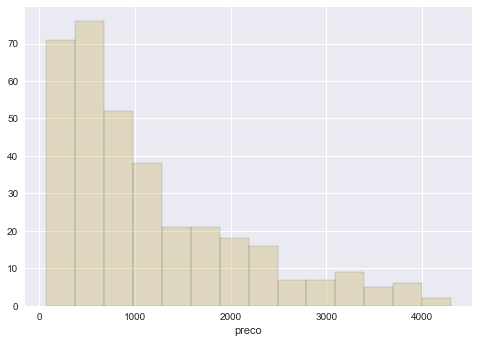

In [311]:
seaborn.distplot(preco.dropna(),
                 kde=False,
                 color="y",
                 hist_kws={"edgecolor": "black"})

### `Camera traseira` ###

Esta variável possui 35 possíveis valores que definem a qualidade da câmera em megapixels, da mais baixa, **vga**, até a mais alta, **41 megapixels**, com moda definina sobre a categoria **5 megapixels**. É interessante observar que, apesar da qualidade mais alta ser **41 megapixels**, a moda é de uma qualidade bem inferior. Observando bem, se percebe que boa parte dos celulares oferecidos tem uma câmera inferior ou igual à **8 megapixels**, aproximadamente 1/5 do valor máximo encontrado. Um estudo com outras variáveis talvez justifique a razão deste comportamento.

### `Velocidade do Processador` ###

Esta variável possui 23 possíveis valores que definem a velocidade do processador em GHz, da mais baixa, **1.0**, até a mais alta, **3.6**, com moda definina sobre a categoria **1.0**. Um comportamento semelhante à variável `câmera frontal` pode ser observado, existem mais especificações de baixa qualidade do que de alta qualidade. E, neste caso, a variável segue um pouco de uma distribuição normal com assimetria à direita.
### `Chips` ###

Esta variável possui 4 possíveis valores que definem a quantidade de chips que o celular suporta. Não é uma variável tão interessante assim, mas é curioso observar que é bem mais comum do que se imagina a existência de celulares dual-chip.

### `Resolução` ###

Esta variável possui 78 possíveis valores que definem a resolução da tela do aparelho em pixels. Também não parece ser uma variável que trás muito informação consigo. A moda é a tela com resolução **240 x 320**. O interessate talvez seja que os picos ocorrem com muito mais frequência para telas de maiores dimensões do que para menores.

### `Tamanho de tela` ###

Esta variável possui 71 possívels valores que definem o tamanho da tela do celular em polegadas. Para melhor analisar a variável, foi proposta quebrá-la em 6 bins difenretes, como mostrado no gráfico de distribuição da variável. Apesar de perder informação, foi ganho o fato de que é muito mais comum telas entre 2-3 polegadas do que as restantes.

### `Memória RAM` ###

Esta variável possui 7 possíveis valores que definem a quantidade de memória RAM do aparelho, em gibabytes. Apesar de poucos valores e não exibir uma distribuição fácil de idenficar, o que se pode observar é a tendência do aumento de memória RAM dos aparelhos. Apesar da maioria ser com **1 GB** ou **2 GB**, existe um considerável quantidade de aparelhos em **3 GB** e **4 GB** e, conhecendo um pouco da evolução dos aparelhos móveis, podemos afirmar que é uma tendência essa maior quantidade.

### `Câmera frontal` ###

Esta variável possui 22 possíveis valores que definem a qualidade da câmera frontal em megapixels, da mais baixa, **vga**, até a mais alta, **16 megapixels**, com moda definida sobre a categoria **5 megapixels**. O destaque dessa variável é o fato da moda ser igual à moda da `câmera frontal`, o que não era esperado. O interessanta talvez seja analisar a relação das duas variáveis e idenficar o que acontece quando uma delas é fixada para **5 megapixels**, o que acontece com a outra. Apesar disto, a mesma observação encontrada para `câmera frontal` pode ser encontrada aqui, existem mais aparelhos à venda com baixa qualidade de câmera.

### Marca ###

Esta variável possui 59 possíveis valores que definem uma amostra das marcas de celulares que a Buscapé vende. Apesar do primeiro pensamento esperado ser que as maiores marcas sejam **Apple** e **Samsumg**, isto não é verdade, pois a **Apple** não possui grande diversidade de linha de aparelhos móveis. O que esta variável indica é a variade de aparelho de uma marca, sendo os destaques **Samsumg**, **LG**, **Nokia** e **Motorola**.


### `Memória interna` ###

Esta variável possui 11 possíveis valores que definem a quantidade de memória interna que o celular possui, em gigabytes. É importante lembrar que nem todos os celulares oferecem grande memória interna, em troca, os mesmos oferecem habilidade de expansão de memória externa. Fato interessante dessa variável é que sua distribuição parece seguir uma distribuição normal, com a maioria dos celulares entre **4 GB** de memória e **32 GB**.

### `Preço` ###

Esta variável é uma variável contínua e define o preço o aparelho móvel. Ao total, apenas 349 aparelhos possuem preços listados no Buscapé, o restante se encontra indisponível no estoque. É interessante observar que, apesar da média ser bastante alta (**R\$1131,41**), isto só se deve ao fato de existir valores altos na extremidade direita da distribuição. Pela variável tender a seguir uma distribuição normal assimétrica à direita, isto é um comportamento normal e logo, uma medidade de centralidade melhor seria a mediana, que indica um preço de **R\$799,00**.


## 2. Análise multivariada ##

Na fase de análise multivariada, iremos analisar principalmente como o preço varia de acordo com certas características dos aparelhos móveis. Para isto, decidimos fixar 5 características principais que consideramos ao comprar um aparelho móvel:  
1. Memória interna
2. Memória RAM
3. Velocidade do processador
4. Qualidade da câmera traseira
5. Qualidade da câmera frontal


,camera_traseira,velocidade_do_processador,url,chips,resolucao,tamanho_da_tela,modelo,memoria_ram,linha,preco,camera_frontal,marca,memoria_interna
147,12.0 megapixels,NaN,http://www.buscape.com.br/smartphone-apple-iph...,single,1920 x 1080,5.5,6s plus 16gb,NaN,iphone,2799.0,5.0 megapixels frontal,apple,16.0
223,13.0 megapixels,2.5,http://www.buscape.com.br/smartphone-asus-zenf...,dual,1920 x 1080,5.5,2 deluxe special edition,4.0,zenfone,2469.9,5.0 megapixels frontal,asus,256.0
342,20.7 megapixels,NaN,http://www.buscape.com.br/detalhes--smartphone...,dual,1080 x 1920,5.2,z3 d6633,NaN,xperia,2896.0,2.2 megapixels frontal,sony,16.0
428,8.0 megapixels,NaN,http://www.buscape.com.br/detalhes--smartphone...,single,1920 x 1080,5.5,6 plus 16gb,1.0,iphone,3287.0,1.2 megapixels frontal,apple,16.0
543,12.0 megapixels,NaN,http://www.buscape.com.br/detalhes--smartphone...,single,1334 x 750,4.7,6s 16gb,NaN,iphone,3799.0,5.0 megapixels frontal,apple,16.0


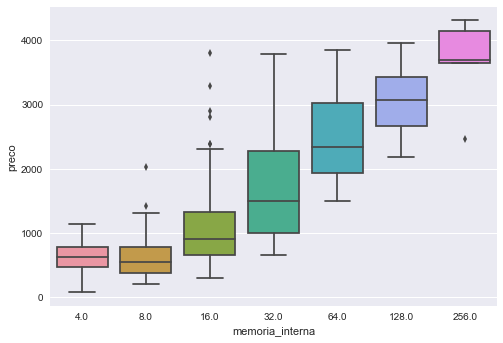

In [312]:
seaborn.boxplot(x="memoria_interna",
                y="preco",
                data=buscape_data[
                    buscape_data["memoria_interna"] >= 4
                ]
                )

buscape_data[
    ((buscape_data["memoria_interna"] == 16) & 
     (buscape_data["preco"] >= 2500)) |
    ((buscape_data["memoria_interna"] == 256) & 
     (buscape_data["preco"] < 3000))]

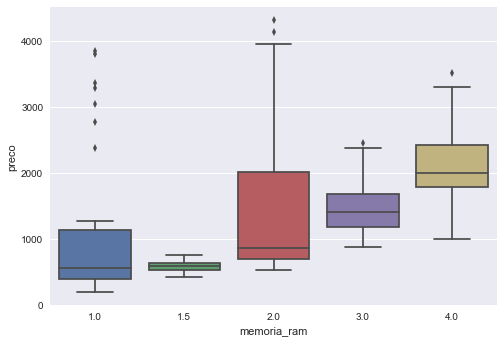

In [313]:
seaborn.boxplot(x="memoria_ram",
                y="preco",
                data=buscape_data[
                    buscape_data["memoria_ram"] >= 1
                ]
                )

,camera_traseira,velocidade_do_processador,url,chips,resolucao,tamanho_da_tela,modelo,memoria_ram,linha,preco,camera_frontal,marca,memoria_interna,bin_velocidade_do_processador
241,8.0 megapixels,1.2,http://www.buscape.com.br/detalhes--smartphone...,single,1136 x 640,4.0,5 16gb,NaN,iphone,2174.0,1.2 megapixels frontal,apple,16.0,"[1.0, 1.5)"
338,8.0 megapixels,1.3,http://www.buscape.com.br/detalhes--smartphone...,single,1136 x 640,4.0,5c 16gb,NaN,iphone,2218.0,1.2 megapixels frontal,apple,16.0,"[1.0, 1.5)"
347,8.0 megapixels,1.3,http://www.buscape.com.br/detalhes--smartphone...,single,1136 x 640,4.0,5s 32gb,1.0,iphone,3360.0,1.2 megapixels frontal,apple,32.0,"[1.0, 1.5)"
541,8.0 megapixels,1.3,http://www.buscape.com.br/detalhes--smartphone...,single,1136 x 640,4.0,5s 64gb,1.0,iphone,3843.0,1.2 megapixels frontal,apple,64.0,"[1.0, 1.5)"
610,8.0 megapixels,1.4,http://www.buscape.com.br/detalhes--smartphone...,single,720 x 1280,4.8,s iii gt-i9305,NaN,galaxy,1520.0,1.9 megapixels frontal,samsung,16.0,"[1.0, 1.5)"
702,8.0 megapixels,1.3,http://www.buscape.com.br/detalhes--smartphone...,single,1136 x 640,4.0,5c 32gb,NaN,iphone,2740.0,1.2 megapixels frontal,apple,32.0,"[1.0, 1.5)"


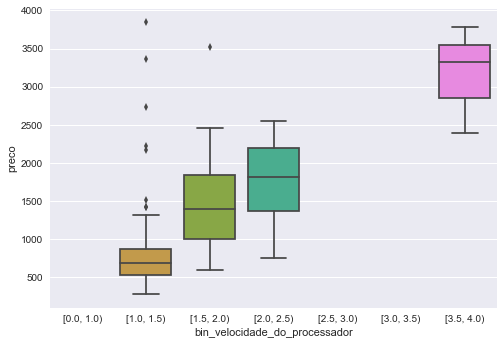

In [314]:
buscape_data["bin_velocidade_do_processador"] = \
    pandas.cut(
        buscape_data["velocidade_do_processador"],
        [0, 1, 1.5, 2, 2.5, 3, 3.5, 4],
        right=False
    )

seaborn.boxplot(x="bin_velocidade_do_processador",
                y="preco",
                data=buscape_data[
                    (buscape_data["velocidade_do_processador"] < 2.5) |
                    (buscape_data["velocidade_do_processador"] >= 3.5)
                ]
                )

buscape_data[
    (buscape_data["velocidade_do_processador"] >= 1.0) &
    (buscape_data["velocidade_do_processador"] < 1.5) &
    (buscape_data["preco"] >= 1500)
]

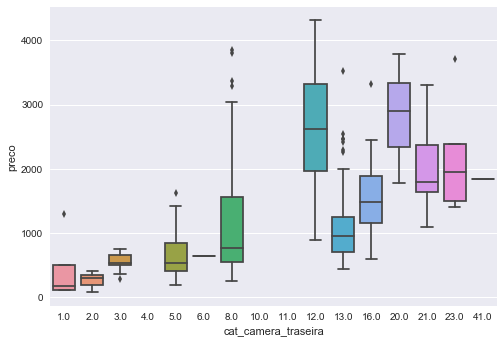

In [315]:
def smaller_order_camera(value):
    value = order_camera_traseria_categories(value)
    return math.floor(value)

buscape_data["cat_camera_traseira"] = \
    buscape_data["camera_traseira"].dropna().apply(
        smaller_order_camera)

buscape_data["cat_camera_traseira"].head()
seaborn.boxplot(x="cat_camera_traseira",
                y="preco",
                data=buscape_data[
                    buscape_data["cat_camera_traseira"] >= 1
                ]
                )

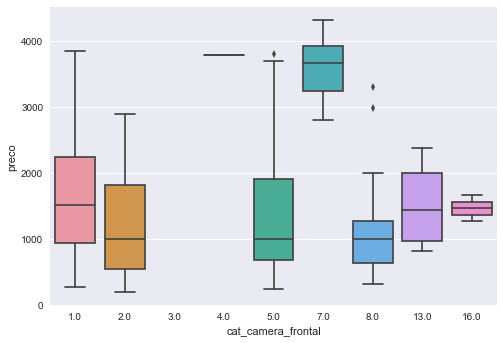

In [316]:
buscape_data["cat_camera_frontal"] = \
    buscape_data["camera_frontal"].dropna().apply(
        smaller_order_camera)

buscape_data["cat_camera_frontal"].head()
seaborn.boxplot(x="cat_camera_frontal",
                y="preco",
                data=buscape_data[
                    buscape_data["cat_camera_frontal"] >= 1
                ]
                )

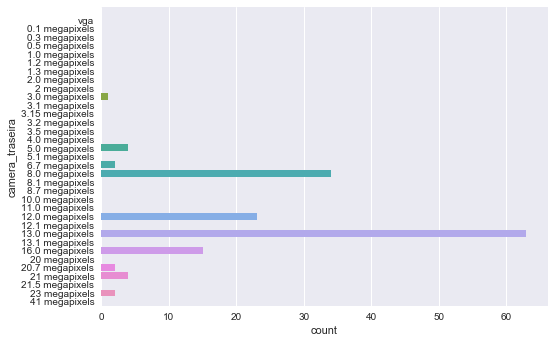

In [327]:
seaborn.countplot(
    y="camera_traseira",
    data=buscape_data[
        buscape_data["cat_camera_frontal"] == 5.0
    ],
    order=camera_traseira.cat.categories
)

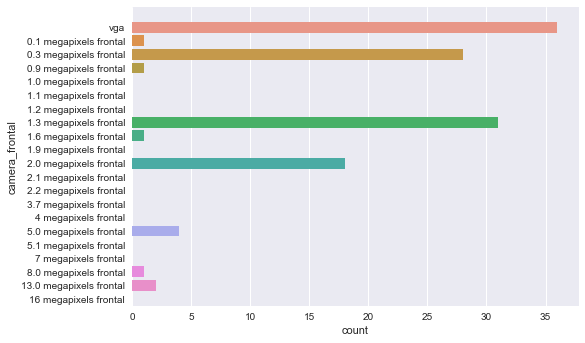

In [328]:
seaborn.countplot(
    y="camera_frontal",
    data=buscape_data[
        buscape_data["cat_camera_traseira"] == 5.0
    ],
    order=camera_frontal.cat.categories
)

### `Memória interna` ###

Parece haver uma forte correlação entre o preço de um aparelho móvel e a quantidade de memória interna que o mesmo possui. Além disso, a variância parece aumentar com o aumento da memória, mas nada parece justificar o porquê. Há alguns outliers marcantes na categoria de **16 GB** e um na categoria de **256 GB**. Ao examinar esses outliers, se percebe que três deles são modelos de iphones (**6s** e **6s plus**) e o outro de **16 GB** é um modelo de xperia com alta resolução de câmera traseira, o que poderia justificar o preço. Com relação ao outlier de **256 GB**, este é um celular **zenfone** da maraca **Asus**, um aparelho muito mais barato comparado com modelos da **Apple**.

### `Memória RAM` ###

Assim como com relação à `memória interna`, a variável `memória RAM` parece também afetar o preço dos aparelhos, mas de uma forma muito menos significante e com uma variância muito maior em cada categoria. Apesar disto, não parece surgir nenhum comportamento interessante como no caso da memória interna. É importante apenas ressaltar que a variância significantemente alta no caso da memória RAM de **2 GB** é provavelmente devido ao número considerável de amostras que essa categoria tem com relação as outras.

### `Velocidade do processador` ###

`velocidade do precessador` parece ser também uma variável que impacta no aumento do preço dos aparelhos celulares. Há também uma certa quantidade significativa de outliers quando se observa o intervalo **[1.0, 1.5) GHz** de processamento. No entanto, ao analisar quais são esses aparelhos, se percebe que os mais caros deles são aparelhos **Apple** da versão 5, que possui um menor poder de processamento, mas ainda sim acima dos valores do mercado por ser um produto **Apple** e o mais barato dos outliers é um **Samsumg**, que também possui um preço mais acima do mercado.

### `Qualidade de câmera traseira` e `Qualidade de câmera frontal` ###

Pela questão das duas variáveis se trarem do mesmo assunto, *qualidade da câmera*, elas serão analisadas juntas, até porque apresentaram padrões semelhantes. A primeira observação que se destaca das outras variáveis analisadas é que não existe uma relação óbvia entre o preço do aparelho celular e da qualidade de câmera, o preço parece variar bastante entre as categorias da qualidade.  
Resolvemos também analisar o comportamento da moda de ambas as variáveis serem **5 megapixels**. Ao exibir o gráfico de distribuição de cada variável filtrando quando a variável oposta tem valor da moda, se percebe um comportamente bastante oposto, quando a variável `câmera frontal` assume valor **5 megapixels**, é muito mais comum ter valores altos na variável `câmera traseira`, já quando a variável `câmera traseira` assume este valor, a `câmera frontal` assume valores de pior qualidade. O que se idenfica é um padrão já conhecido, o desenvolvimento da câmera frontal é mais lento que o da câmera traseira.